<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [6]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data =  data.fillna(method='ffill')
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
print(f" len of vocab {len(data.Word.unique())}")
print(len(data.Tag.unique()))
print(data.Tag.value_counts())



35178
17
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


In [17]:
words = list(set(data.Word.values))
words.append("ENDPAD")
num_words = len(words)
print(words[0:10])

['Welt', 'alleged', 'spat', 'geological', 'synchronize', 'halting', 'pieced', 'downtown', 'Presidents', 'Dans']


In [16]:
tags = list(set(data.Tag))
num_tags = len(tags)
print(num_tags)

17


### Task 3: Retrieve Sentences and Corresponsing Tags

In [23]:
class SentenceGetter:
    def __init__(self,  data):
        self.n_sents = 1
        self.data = data 
        agg_func = lambda s: [(w, p, t) for w,p,t in zip(s.Word.values.tolist(),\
                                                        s.POS.values.tolist(),\
                                                        s.Tag.values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s  in self.grouped ]
        

In [27]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')]]

In [28]:
print(len(getter.sentences))

47959


### Task 4: Define Mappings between Sentences and Tags

In [29]:
word2idx =  {w: i+1 for i,w in enumerate(words)}
tag2idx = {t:i for i,t in enumerate(tags)}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

64


(array([1.300e+01, 1.800e+02, 7.030e+02, 1.363e+03, 2.152e+03, 2.803e+03,
        3.496e+03, 3.965e+03, 4.559e+03, 4.849e+03, 4.706e+03, 4.447e+03,
        3.814e+03, 3.117e+03, 2.433e+03, 1.699e+03, 1.767e+03, 6.490e+02,
        4.720e+02, 2.660e+02, 1.710e+02, 1.050e+02, 7.300e+01, 5.900e+01,
        2.400e+01, 1.800e+01, 2.100e+01, 6.000e+00, 9.000e+00, 6.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   3.06,   5.12,   7.18,   9.24,  11.3 ,  13.36,  15.42,
         17.48,  19.54,  21.6 ,  23.66,  25.72,  27.78,  29.84,  31.9 ,
         33.96,  36.02,  38.08,  40.14,  42.2 ,  44.26,  46.32,  48.38,
         50.44,  52.5 ,  54.56,  56.62,  58.68,  60.74,  62.8 ,  64.86,
         66.92,  68.98,  71.04,  73.1 ,  75.16,  77.22,  79.28,  81.34,
         83.4 , 

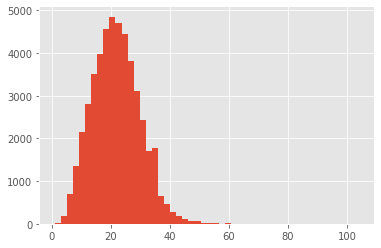

In [38]:
print(len(max(words, key=len)))

plt.hist([len(s) for s in sentences], bins=50)


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff72c493b70>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff72c4a0278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff72c493a20>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff72c4a0908>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff72c4a0c50>],
 'means': []}

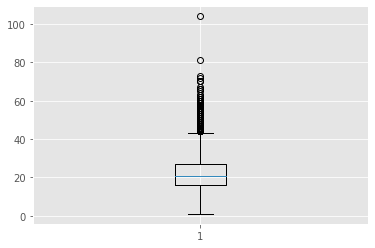

In [39]:
plt.boxplot([len(s) for s in sentences])

In [44]:
# It's safe to choose len == 45

from tensorflow.keras.preprocessing.sequence  import pad_sequences
from tensorflow.keras.utils import to_categorical 

max_len = 45
X  = [[word2idx[w[0]]  for w in s] for s  in sentences]
X = pad_sequences(sequences=X, maxlen=max_len, padding='post', value=num_words-1)

y = [[tag2idx[w[2]]  for w in s] for s  in sentences]
y = pad_sequences(sequences=y, maxlen=max_len, padding='post', value=tag2idx['O'])
y= [to_categorical(i, num_classes=num_tags) for i in y]

In [46]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [47]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [50]:
input_layer = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_layer)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True,  recurrent_dropout=0.1))(model)
out =  TimeDistributed(Dense(num_tags,  activation='softmax'))(model)

model = Model(input_layer, out)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 45)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 45, 45)            1583055   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 45, 45)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 45, 200)           116800    
_________________________________________________________________
time_distributed (TimeDistri (None, 45, 17)            3417      
Total params: 1,703,272
Trainable params: 1,703,272
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer='adam', \
             loss='categorical_crossentropy',\
             metrics=['accuracy'])

### Task 7: Train the Model

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

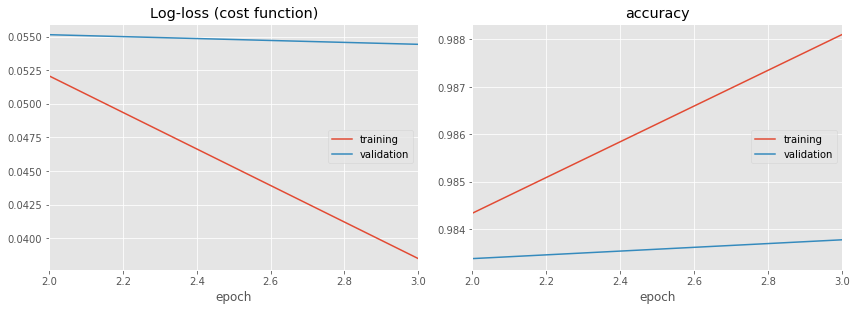

Log-loss (cost function):
training   (min:    0.038, max:    0.166, cur:    0.038)
validation (min:    0.054, max:    0.069, cur:    0.054)

accuracy:
training   (min:    0.960, max:    0.988, cur:    0.988)
validation (min:    0.979, max:    0.984, cur:    0.984)
30214/30214 [==============================] - 288s 10ms/sample - loss: 0.0385 - accuracy: 0.9881 - val_loss: 0.0544 - val_accuracy: 0.9838


In [55]:
early_stopping  = EarlyStopping(monitor='val_accuracy', patience=2, verbose=0,
                                mode='max', restore_best_weights=False)
callbacks=[PlotLossesCallback(),  early_stopping]

history = model.fit(x_train, np.array(y_train), epochs=3,\
                   callbacks=callbacks, \
                   validation_split=0.3,\
                   batch_size=16,
                   verbose=1)

In [54]:
!nvidia-smi

Tue May 19 00:19:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   58C    P0    61W / 149W |  10942MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Task 8: Evaluate Named Entity Recognition Model

In [56]:
model.evaluate(x_test, np.array(y_test))

4796/4796 [==============================] - 5s 991us/sample - loss: 0.0549 - accuracy: 0.9833


[0.05491415336355256, 0.98327774]

In [66]:
index = np.random.randint(0, x_test.shape[0])
pred = model.predict(np.array([x_test[index]]))
pred = np.argmax(pred, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[index]

print("{:15}{:5}\t {}".format("Word", "True",  "Pred"))
print("-"*30)
for w, true, pred in zip(x_test[index], y_true, pred[0]):
    print("{:15}{:5}\t {}".format(words[w-1], tags[true], tags[pred]))


Word           True 	 Pred
------------------------------
A              O    	 O
Pakistan       B-org	 B-org
TelecommunicationI-org	 I-org
Authority      I-org	 I-org
spokesman      O    	 O
,              O    	 O
Khurram        B-per	 O
Mehran         I-per	 O
,              O    	 O
said           O    	 O
the            O    	 O
sites          O    	 O
that           O    	 O
will           O    	 O
be             O    	 O
monitored      O    	 O
are            O    	 O
Yahoo          B-org	 B-org
,              I-org	 O
Google         I-org	 B-org
,              O    	 O
YouTube        B-org	 B-org
,              O    	 O
Amazon         B-org	 B-org
,              O    	 O
MSN            B-org	 O
,              I-org	 O
Hotmail        I-org	 B-org
and            I-org	 O
Bing           I-org	 O
.              O    	 O
steppe         O    	 O
steppe         O    	 O
steppe         O    	 O
steppe         O    	 O
steppe         O    	 O
steppe         O    	 O
steppe         O    